In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

pd.set_option('display.max_columns', 100)
pd.options.mode.chained_assignment = None  # default='warn'

### Reading data

In [2]:
data = pd.read_excel('Oncothromb_bbddMarzo2018.xlsx')
data.shape

(408, 92)

In [3]:
# considering only rows where 'excluido==0'
data = data[data['excluido']==0]
data.shape # 391 patients

(391, 92)

### Target variable

In [4]:
# target variable 'v0_episodiETV' indicates wheter the patient has sufferend an VTE or not
print(data['v0_episodiETV'].unique())

['Sí' 'No' '-']


In [5]:
data.loc[data['v0_episodiETV']=='-','v0_episodiETV'] = 'No'  # imputing missing value

y = data['v0_episodiETV'].copy()
y.unique()

array(['Sí', 'No'], dtype=object)

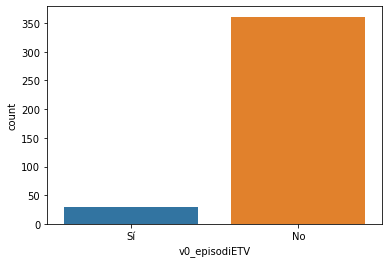

In [6]:
ax = sns.countplot(y)
plt.show()

In [7]:
y.replace('No', 0, inplace=True)
y.replace('Sí', 1, inplace=True)

In [8]:
len(y[y==0]), len(y[y==1])

(361, 30)

### Genetic variables

In [9]:
gen_data = data[['rs6025','rs4524','rs1799963','rs1801020','rs5985','rs121909548','rs2232698',
                'rs8176719','rs7853989','rs8176749','rs8176750']]

In [10]:
gen_data.shape

(391, 11)

In [11]:
print(gen_data['rs6025'].unique()) # risk allele = A
gen_data['rs6025'].replace('GG', 0, inplace=True)
gen_data['rs6025'].replace('AG', 1, inplace=True)

['GG' 'AG']


In [12]:
print(gen_data['rs4524'].unique()) # risk allele = T
gen_data['rs4524'].replace('CC', 0, inplace=True)
gen_data['rs4524'].replace('CT', 1, inplace=True)
gen_data['rs4524'].replace('TT', 2, inplace=True)

['CT' 'TT' 'CC']


In [13]:
print(gen_data['rs1799963'].unique()) # risk allele = A
gen_data['rs1799963'].replace('GG', 0, inplace=True)
gen_data['rs1799963'].replace('AG', 1, inplace=True)
gen_data['rs1799963'].replace('AA', 2, inplace=True)

['GG' 'AG' 'AA']


In [14]:
print(gen_data['rs1801020'].unique()) # risk allele = T
gen_data['rs1801020'].replace('CC', 0, inplace=True)
gen_data['rs1801020'].replace('CT', 1, inplace=True)
gen_data['rs1801020'].replace('TT', 2, inplace=True)

['CC' 'CT' 'TT']


In [15]:
print(gen_data['rs5985'].unique()) # risk allele = T
gen_data['rs5985'].replace('GG', 0, inplace=True)
gen_data['rs5985'].replace('GT', 1, inplace=True)
gen_data['rs5985'].replace('TT', 2, inplace=True)

['GT' 'GG' 'TT']


In [16]:
print(gen_data['rs121909548'].unique()) # risk allele = T
gen_data['rs121909548'].replace('GG', 0, inplace=True)
gen_data['rs121909548'].replace('GT', 1, inplace=True)
# 2 missing values
gen_data['rs121909548'].replace('NoCall', 0, inplace=True) # imputing nan values with 0

['GG' 'NoCall' 'GT']


In [17]:
print(gen_data['rs2232698'].unique()) # risk allele = T
gen_data['rs2232698'].replace('CC', 0, inplace=True)
gen_data['rs2232698'].replace('CT', 1, inplace=True)
# 1 missing value
gen_data['rs2232698'].replace('NoCall', 0, inplace=True) # imputing nan values with 0

['CC' 'CT' 'NoCall']


In [18]:
# A1 blood group (rs8176719, rs7853989, rs8176749, rs8176750)

In [19]:
print(gen_data['rs8176719'].unique()) # G
gen_data['rs8176719'].replace('--', 0, inplace=True)
gen_data['rs8176719'].replace('-G', 1, inplace=True)
gen_data['rs8176719'].replace('GG', 2, inplace=True)

['GG' '--' '-G']


In [20]:
print(gen_data['rs7853989'].unique()) # G
gen_data['rs7853989'].replace('CC', 0, inplace=True)
gen_data['rs7853989'].replace('CG', 1, inplace=True)
gen_data['rs7853989'].replace('GG', 2, inplace=True)
# 2 missing values
gen_data['rs7853989'].replace('NoCall', 0, inplace=True) # imputing nan values with 0

['CC' 'CG' 'NoCall' 'GG']


In [21]:
print(gen_data['rs8176749'].unique()) # A
gen_data['rs8176749'].replace('GG', 0, inplace=True)
gen_data['rs8176749'].replace('AG', 1, inplace=True)
# 1 missing value
gen_data['rs8176749'].replace('NoCall', 0, inplace=True) # imputing nan values with 0

['GG' 'AG' 'NoCall']


In [22]:
print(gen_data['rs8176750'].unique()) # -
gen_data['rs8176750'].replace('CC', 0, inplace=True)
gen_data['rs8176750'].replace('-C', 1, inplace=True)
# 1 missing value
gen_data['rs8176750'].replace('NoCall', 0, inplace=True) # imputing nan values with 0

['CC' '-C' 'NoCall']


In [23]:
gen_data.head()

,rs6025,rs4524,rs1799963,rs1801020,rs5985,rs121909548,rs2232698,rs8176719,rs7853989,rs8176749,rs8176750
1,0,1,0,0,1,0,0,2,0,0,0
2,0,1,0,1,0,0,0,0,0,0,0
3,0,2,0,1,0,0,0,1,0,0,0
4,0,2,0,0,0,0,0,1,0,0,1
5,0,2,0,1,0,0,0,2,0,0,0


In [24]:
len(gen_data[gen_data['rs8176719']==0])

148

In [122]:
sum(y[gen_data[gen_data['rs2232698']==1].index])

0

In [29]:
gen_model = sm.Logit(y, gen_data).fit(maxiter=100)

         Current function value: 0.312784
         Iterations: 100


D:\Anaconda\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [30]:
gen_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          v0_episodiETV   No. Observations:                  391
Model:                          Logit   Df Residuals:                      380
Method:                           MLE   Df Model:                           10
Date:                Thu, 08 Apr 2021   Pseudo R-squ.:                 -0.1555
Time:                        10:49:49   Log-Likelihood:                -122.30
converged:                      False   LL-Null:                       -105.84
Covariance Type:            nonrobust   LLR p-value:                     1.000
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
rs6025          1.0216      0.845      1.209      0.227      -0.635       2.678
rs4524         -1.0507      0.168     -6.271      0.000      -1.379      -0.722
rs1799963      -1.1531      1.075     -1.073      0.283      -3.260       0.954
rs1801020      -0.4203      0.303     -1.389      0.165      -1.014       0.173
rs5985         -0.3657      0.283     -1.293      0.196      -0.920       0.188
rs121909548   -15.4073   7091.049     -0.002      0.998   -1.39e+04    1.39e+04
rs2232698     -23.9219   1.48e+05     -0.000      1.000   -2.91e+05    2.91e+05
rs8176719      -0.2245      0.273     -0.821      0.412      -0.760       0.311
rs7853989       0.5539      1.179      0.470      0.639      -1.757       2.865
rs8176749      -1.0134      1.257     -0.806      0.420      -3.476       1.450
rs8176750      -0.7499      0.673     -1.115      0.265      -2.068       0.568
===============================================================================
"""

### Clinical variables

In [31]:
clinical_data = data[['sexe','edatDx','diabetesM','fumador','Family','bmi','dislip', 'hta_desc','khorana',
                      'tipusTumor_desc','estadiGrup','hemoglobina','plaquetes','leucocits']]

In [32]:
clinical_data.shape

(391, 14)

In [33]:
print(clinical_data['sexe'].unique()) 
clinical_data['sexe'].replace('Hombre', 0, inplace=True)
clinical_data['sexe'].replace('Mujer', 1, inplace=True)

['Hombre' 'Mujer']


In [34]:
print(clinical_data['diabetesM'].unique()) 
clinical_data['diabetesM'].replace('No', 0, inplace=True)
clinical_data['diabetesM'].replace('Sí', 1, inplace=True)
clinical_data['diabetesM'].replace('-', 0, inplace=True) # replace missing values by 0

['-' 'No' 'Sí']


In [35]:
print(clinical_data['fumador'].unique()) 
clinical_data['fumador'].replace('Nunca', 0, inplace=True)
clinical_data['fumador'].replace('Desconocido', 0, inplace=True)
clinical_data['fumador'].replace('Exfumador', 0, inplace=True)
clinical_data['fumador'].replace('Fumador activo', 1, inplace=True)

['Fumador activo' 'Nunca' 'Exfumador' 'Desconocido']


In [36]:
print(clinical_data['bmi'].unique()) 
clinical_data['bmi'].replace('Underweight: BMI < 18.5 Kg/m2', 0, inplace=True)
clinical_data['bmi'].replace('Normal: BMI ~ 18.5-24.9 Kg/m2', 0, inplace=True)
clinical_data['bmi'].replace('Overweight: BMI ~25-29.9 Kg/m2', 1, inplace=True)
clinical_data['bmi'].replace('Obese: BMI > 30 kg/m2', 1, inplace=True)

['Obese: BMI > 30 kg/m2' 'Normal: BMI ~ 18.5-24.9 Kg/m2'
 'Overweight: BMI ~25-29.9 Kg/m2' 'Underweight: BMI < 18.5 Kg/m2']


In [37]:
print(clinical_data['dislip'].unique()) 
clinical_data['dislip'].replace('No', 0, inplace=True)
clinical_data['dislip'].replace('Sí', 1, inplace=True)
clinical_data['dislip'].replace('-', 0, inplace=True) # replace missing values by 0

['-' 'No' 'Sí']


In [38]:
print(clinical_data['hta_desc'].unique()) 
clinical_data['hta_desc'].replace('No', 0, inplace=True)
clinical_data['hta_desc'].replace('Sí', 1, inplace=True)
clinical_data['hta_desc'].replace('-', 0, inplace=True) # replace missing values by 0

['-' 'Sí' 'No']


In [39]:
print(clinical_data['khorana'].unique()) 
clinical_data['khorana'] = [1 if n>=3 else 0 for n in clinical_data['khorana']]
clinical_data['khorana'].replace(np.nan, 0, inplace=True) # replace missing values by 0

[ 2.  1.  0.  3.  4. nan]


In [40]:
print(clinical_data['tipusTumor_desc'].unique()) 
clinical_data['tipusTumor_colon'] = [1 if t=='Cáncer colorrectal' else 0 for t in clinical_data['tipusTumor_desc']]
clinical_data['tipusTumor_pancreas'] = [1 if t=='Cáncer de páncreas' else 0 for t in clinical_data['tipusTumor_desc']]
clinical_data['tipusTumor_pulmon'] = [1 if t=='Cáncer de pulmón no microcítico' else 0 for t in clinical_data['tipusTumor_desc']]
clinical_data['tipusTumor_esofago'] = [1 if t=='Cáncer esófago' else 0 for t in clinical_data['tipusTumor_desc']]
clinical_data['tipusTumor_estomago'] = [1 if t=='Cáncer gástrico o de estómago' else 0 for t in clinical_data['tipusTumor_desc']]
clinical_data.drop('tipusTumor_desc', axis=1, inplace=True)

['Cáncer esófago' 'Cáncer gástrico o de estómago'
 'Cáncer de pulmón no microcítico' 'Cáncer colorrectal'
 'Cáncer de páncreas']


In [41]:
print(clinical_data['estadiGrup'].unique()) 
clinical_data['estadiGrup_I_II'] = [1 if g in ['IA','IB','IIA','IIB','IIC'] else 0 for g in clinical_data['estadiGrup']]
clinical_data['estadiGrup_III'] = [1 if g in ['III','IIIA','IIIB','IIIC'] else 0 for g in clinical_data['estadiGrup']]
clinical_data['estadiGrup_IV'] = [1 if g in ['IV','IVA','IVB'] else 0 for g in clinical_data['estadiGrup']]
clinical_data.drop('estadiGrup', axis=1, inplace=True)

['IV' 'IIB' 'IVB' 'IVA' 'IIIC' 'IIA' 'IB' 'IIIB' 'III' 'IIIA' 'IIC' 'IA']


In [42]:
clinical_data['hemoglobina'] = [1 if n<10 else 0 for n in clinical_data['hemoglobina']]
clinical_data['plaquetes'] = [1 if n>350000 else 0 for n in clinical_data['plaquetes']]
clinical_data['leucocits'] = [1 if n>11000 else 0 for n in clinical_data['leucocits']]

In [43]:
clinical_data.head()

,sexe,edatDx,diabetesM,fumador,Family,bmi,dislip,hta_desc,khorana,hemoglobina,plaquetes,leucocits,tipusTumor_colon,tipusTumor_pancreas,tipusTumor_pulmon,tipusTumor_esofago,tipusTumor_estomago,estadiGrup_I_II,estadiGrup_III,estadiGrup_IV
1,0,50,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0,71,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0
3,0,68,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1
4,0,71,1,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1
5,0,59,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1


In [44]:
clinical_data.shape

(391, 20)

In [60]:
len(clinical_data[clinical_data['khorana']==1])

74

In [61]:
sum(y[clinical_data[clinical_data['khorana']==1].index])

8

In [47]:
# fit the model with maximum likelihood function
clinical_model = sm.Logit(endog=y, exog=clinical_data).fit(maxiter=100)

         Current function value: 0.186895
         Iterations: 100


D:\Anaconda\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [48]:
clinical_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          v0_episodiETV   No. Observations:                  391
Model:                          Logit   Df Residuals:                      372
Method:                           MLE   Df Model:                           18
Date:                Thu, 08 Apr 2021   Pseudo R-squ.:                  0.3096
Time:                        10:52:24   Log-Likelihood:                -73.076
converged:                      False   LL-Null:                       -105.84
Covariance Type:            nonrobust   LLR p-value:                 2.533e-07
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
sexe                    0.5697      0.475      1.200      0.230      -0.361       1.500
edatDx                  0.0189      0.025      0.757      0.449      -0.030       0.068
diabetesM              -0.2837      0.566     -0.501      0.616      -1.394       0.826
fumador                 0.6794      0.524      1.296      0.195      -0.348       1.707
Family                  0.8831      0.857      1.030      0.303      -0.797       2.563
bmi                     0.0806      0.492      0.164      0.870      -0.884       1.046
dislip                  0.8625      0.474      1.820      0.069      -0.067       1.792
hta_desc                0.0367      0.468      0.078      0.938      -0.881       0.954
khorana                 0.4553      0.961      0.474      0.636      -1.429       2.339
hemoglobina           -28.3365   1.67e+06   -1.7e-05      1.000   -3.27e+06    3.27e+06
plaquetes              -1.2914      0.849     -1.521      0.128      -2.956       0.373
leucocits              -0.1368      0.786     -0.174      0.862      -1.677       1.403
tipusTumor_colon       -5.4123   2.02e+07  -2.68e-07      1.000   -3.95e+07    3.95e+07
tipusTumor_pancreas    -3.6703   2.02e+07  -1.82e-07      1.000   -3.95e+07    3.95e+07
tipusTumor_pulmon      -6.3516   2.02e+07  -3.15e-07      1.000   -3.95e+07    3.95e+07
tipusTumor_esofago     -4.0594   2.02e+07  -2.01e-07      1.000   -3.95e+07    3.95e+07
tipusTumor_estomago    -6.4233   2.02e+07  -3.18e-07      1.000   -3.95e+07    3.95e+07
estadiGrup_I_II       -27.3921   2.02e+07  -1.36e-06      1.000   -3.95e+07    3.95e+07
estadiGrup_III          0.4137   2.02e+07   2.05e-08      1.000   -3.95e+07    3.95e+07
estadiGrup_IV           1.0615   2.02e+07   5.26e-08      1.000   -3.95e+07    3.95e+07
=======================================================================================

Possibly complete quasi-separation: A fraction 0.23 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

### Genetical and clinical markers included in the TiC-Onco risk score model

In [80]:
X = pd.concat([gen_data[['rs2232698','rs6025','rs5985','rs4524']], clinical_data[['bmi','Family']]], axis=1)

In [91]:
print(data['tipusTumor_desc'].unique()) 
X['primary_tumour_site'] = [1 if t=='Cáncer de pulmón no microcítico' else 2 if t in ['Cáncer gástrico o de estómago','Cáncer de páncreas'] else 0 for t in data['tipusTumor_desc']]

['Cáncer esófago' 'Cáncer gástrico o de estómago'
 'Cáncer de pulmón no microcítico' 'Cáncer colorrectal'
 'Cáncer de páncreas']


In [93]:
print(data['estadiGrup'].unique()) 
X['tumour_stage'] = [1 if t in ['IV','IVA','IVB'] else 0 for t in data['estadiGrup']]

['IV' 'IIB' 'IVB' 'IVA' 'IIIC' 'IIA' 'IB' 'IIIB' 'III' 'IIIA' 'IIC' 'IA']


In [95]:
X.head()

,rs2232698,rs6025,rs5985,rs4524,bmi,Family,primary_tumour_site,tumour_stage
1,0,0,1,1,1,0,0,1
2,0,0,0,1,0,0,2,0
3,0,0,0,2,0,0,1,1
4,0,0,0,2,0,0,0,1
5,0,0,0,2,1,0,0,1


In [96]:
X.shape

(391, 8)

### Evaluating TiC-Onco risk score

In [108]:
model = sm.Logit(endog=y, exog=X).fit(maxiter=100)

Optimization terminated successfully.
         Current function value: 0.309614
         Iterations 39


In [109]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          v0_episodiETV   No. Observations:                  391
Model:                          Logit   Df Residuals:                      383
Method:                           MLE   Df Model:                            7
Date:                Thu, 08 Apr 2021   Pseudo R-squ.:                 -0.1438
Time:                        11:46:09   Log-Likelihood:                -121.06
converged:                       True   LL-Null:                       -105.84
Covariance Type:            nonrobust   LLR p-value:                     1.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
rs2232698            -110.7782   9.41e+23  -1.18e-22      1.000   -1.84e+24    1.84e+24
rs6025                  1.1337      0.857      1.323      0.186      -0.546       2.814
rs5985                 -0.3992      0.291     -1.371      0.170      -0.970       0.171
rs4524                 -1.1911      0.179     -6.655      0.000      -1.542      -0.840
bmi                    -0.9874      0.341     -2.896      0.004      -1.656      -0.319
Family                  0.5981      0.700      0.855      0.393      -0.773       1.969
primary_tumour_site    -0.0598      0.182     -0.328      0.743      -0.417       0.298
tumour_stage            0.3274      0.337      0.972      0.331      -0.333       0.987
=======================================================================================
"""

In [139]:
y_pred = model.predict(X)

In [132]:
fpr, tpr, thresholds = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.502770083102493


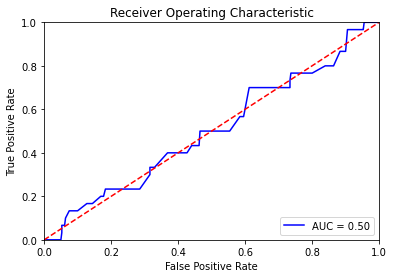

In [133]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [138]:
print((1-fpr)[24]) # FPR = 1-specificity
threshold = thresholds[24] # threshold (specificity ~ 80%)
print(threshold)

0.7894736842105263
0.16109879702363034


In [151]:
y_hat = y_pred >= threshold
acc = sum(y_hat == y) / len(y)
print("Accuracy (%):", round(acc*100, 2))

Accuracy (%): 74.68


In [152]:
tn, fp, fn, tp = confusion_matrix(y, y_hat).ravel()
confusion_matrix(y, y_hat)

array([[285,  76],
       [ 23,   7]], dtype=int64)

In [153]:
sensivity = tp / (tp+fn)
specificity = tn / (fp+tn)
PPV = tp / (tp+fp)
NPV = tn / (fn+tn)

In [154]:
print("Sensivity (%):", round(sensivity*100,2))
print("Specificity (%):", round(specificity,4)*100)
print("PPV (%):", round(PPV,4)*100)
print("NPV (%):", round(NPV,4)*100)

Sensivity (%): 23.33
Specificity (%): 78.95
PPV (%): 8.43
NPV (%): 92.53


### Evaluating Khorana score

In [54]:
# High risk: Khorana >= 3
pred_khorana = [1 if score>=3 else 0 for score in data['khorana']]
len(pred_khorana)

391

In [77]:
acc_khorana = sum(pred_khorana == y) / len(y)
print("Accuracy (%):", round(acc_khorana*100, 2))

Accuracy (%): 77.49


In [65]:
tn, fp, fn, tp = confusion_matrix(y, pred_khorana).ravel()
confusion_matrix(y, pred_khorana)

array([[295,  66],
       [ 22,   8]], dtype=int64)

In [67]:
sensivity_khorana = tp / (tp+fn)
specificity_khorana = tn / (fp+tn)
PPV_khorana = tp / (tp+fp)
NPV_khorana = tn / (fn+tn) 

In [74]:
print("Sensivity (%):", round(sensivity_khorana*100,2))
print("Specificity (%):", round(specificity_khorana,4)*100)
print("PPV (%):", round(PPV_khorana,4)*100)
print("NPV (%):", round(NPV_khorana,4)*100)

Sensivity (%): 26.67
Specificity (%): 81.72
PPV (%): 10.81
NPV (%): 93.06
